Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
def angle_embedding(circuit, qubits, data):
    """Apply angle (RY) encoding for 9-dimensional data."""
    for i in range(len(data)):
        circuit.ry(data[i], qubits[i])

def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)

def swap_test_circuit(data1, data2):
    assert len(data1) == len(data2) == 9, "Expect 9-dimensional inputs"

    # Registers: 1 ancilla + 9 data qubits each
    anc = QuantumRegister(1, name='anc')
    q1 = QuantumRegister(9, name='qA')
    q2 = QuantumRegister(9, name='qB')
    c = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(anc, q1, q2, c)

    # Hadamard on ancilla
    qc.h(anc[0])

    # Angle encode both states
    angle_embedding(qc, q1, data1)
    angle_embedding(qc, q2, data2)

    # Apply iQFT to both states
    inverse_qft(qc, q1)
    inverse_qft(qc, q2)

    # Controlled SWAP test
    for i in range(9):
        qc.cswap(anc[0], q1[i], q2[i])

    # Final Hadamard and measure
    qc.h(anc[0])
    qc.measure(anc[0], c[0])

    return qc


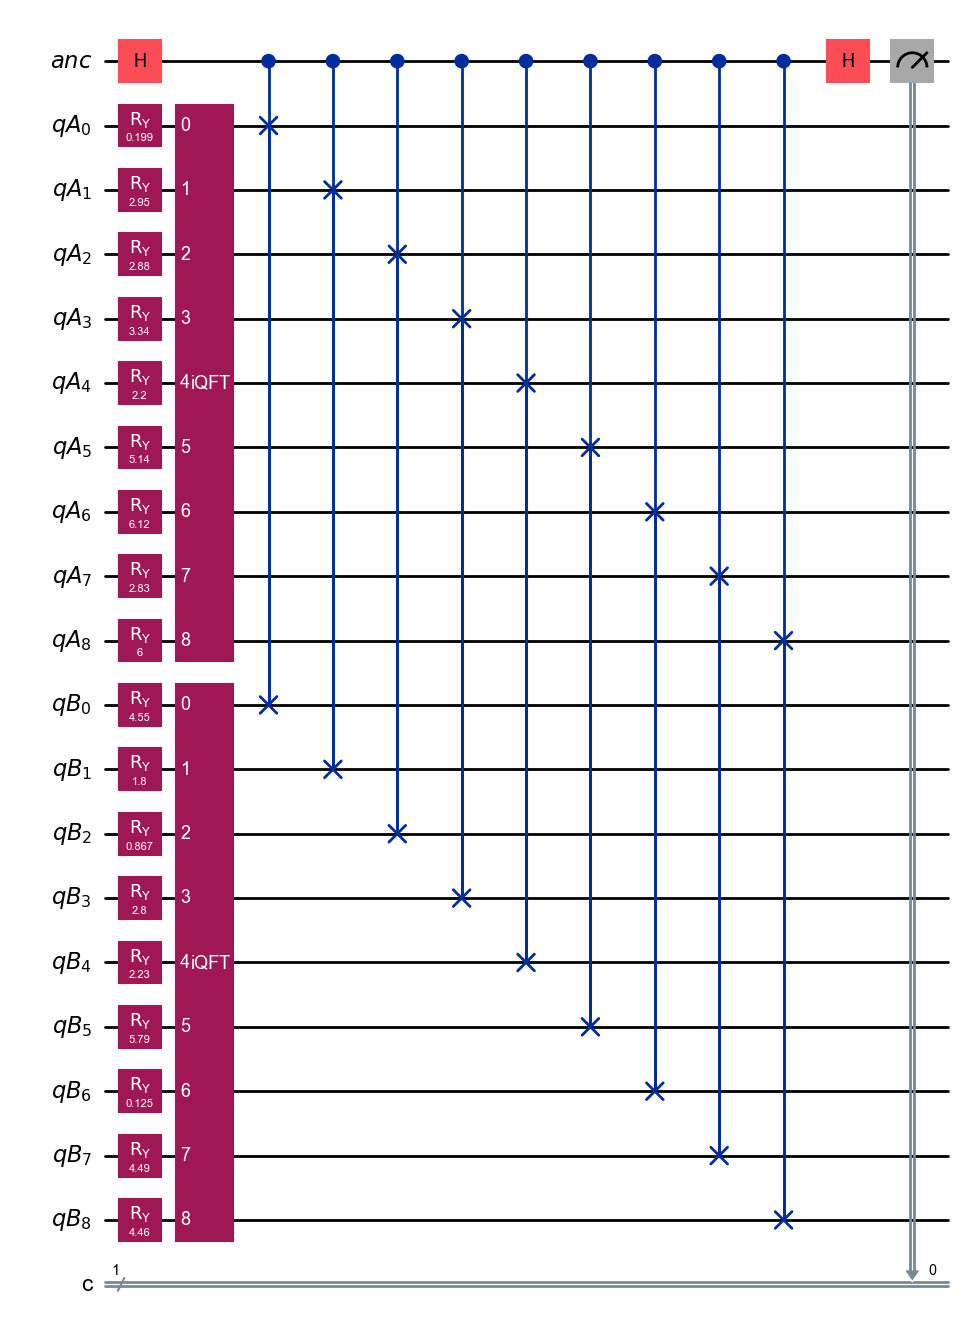

In [15]:
data1 = np.random.uniform(0, 2*np.pi, 9)  # 9 features
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_test_circuit(data1, data2)
qc.draw('mpl')

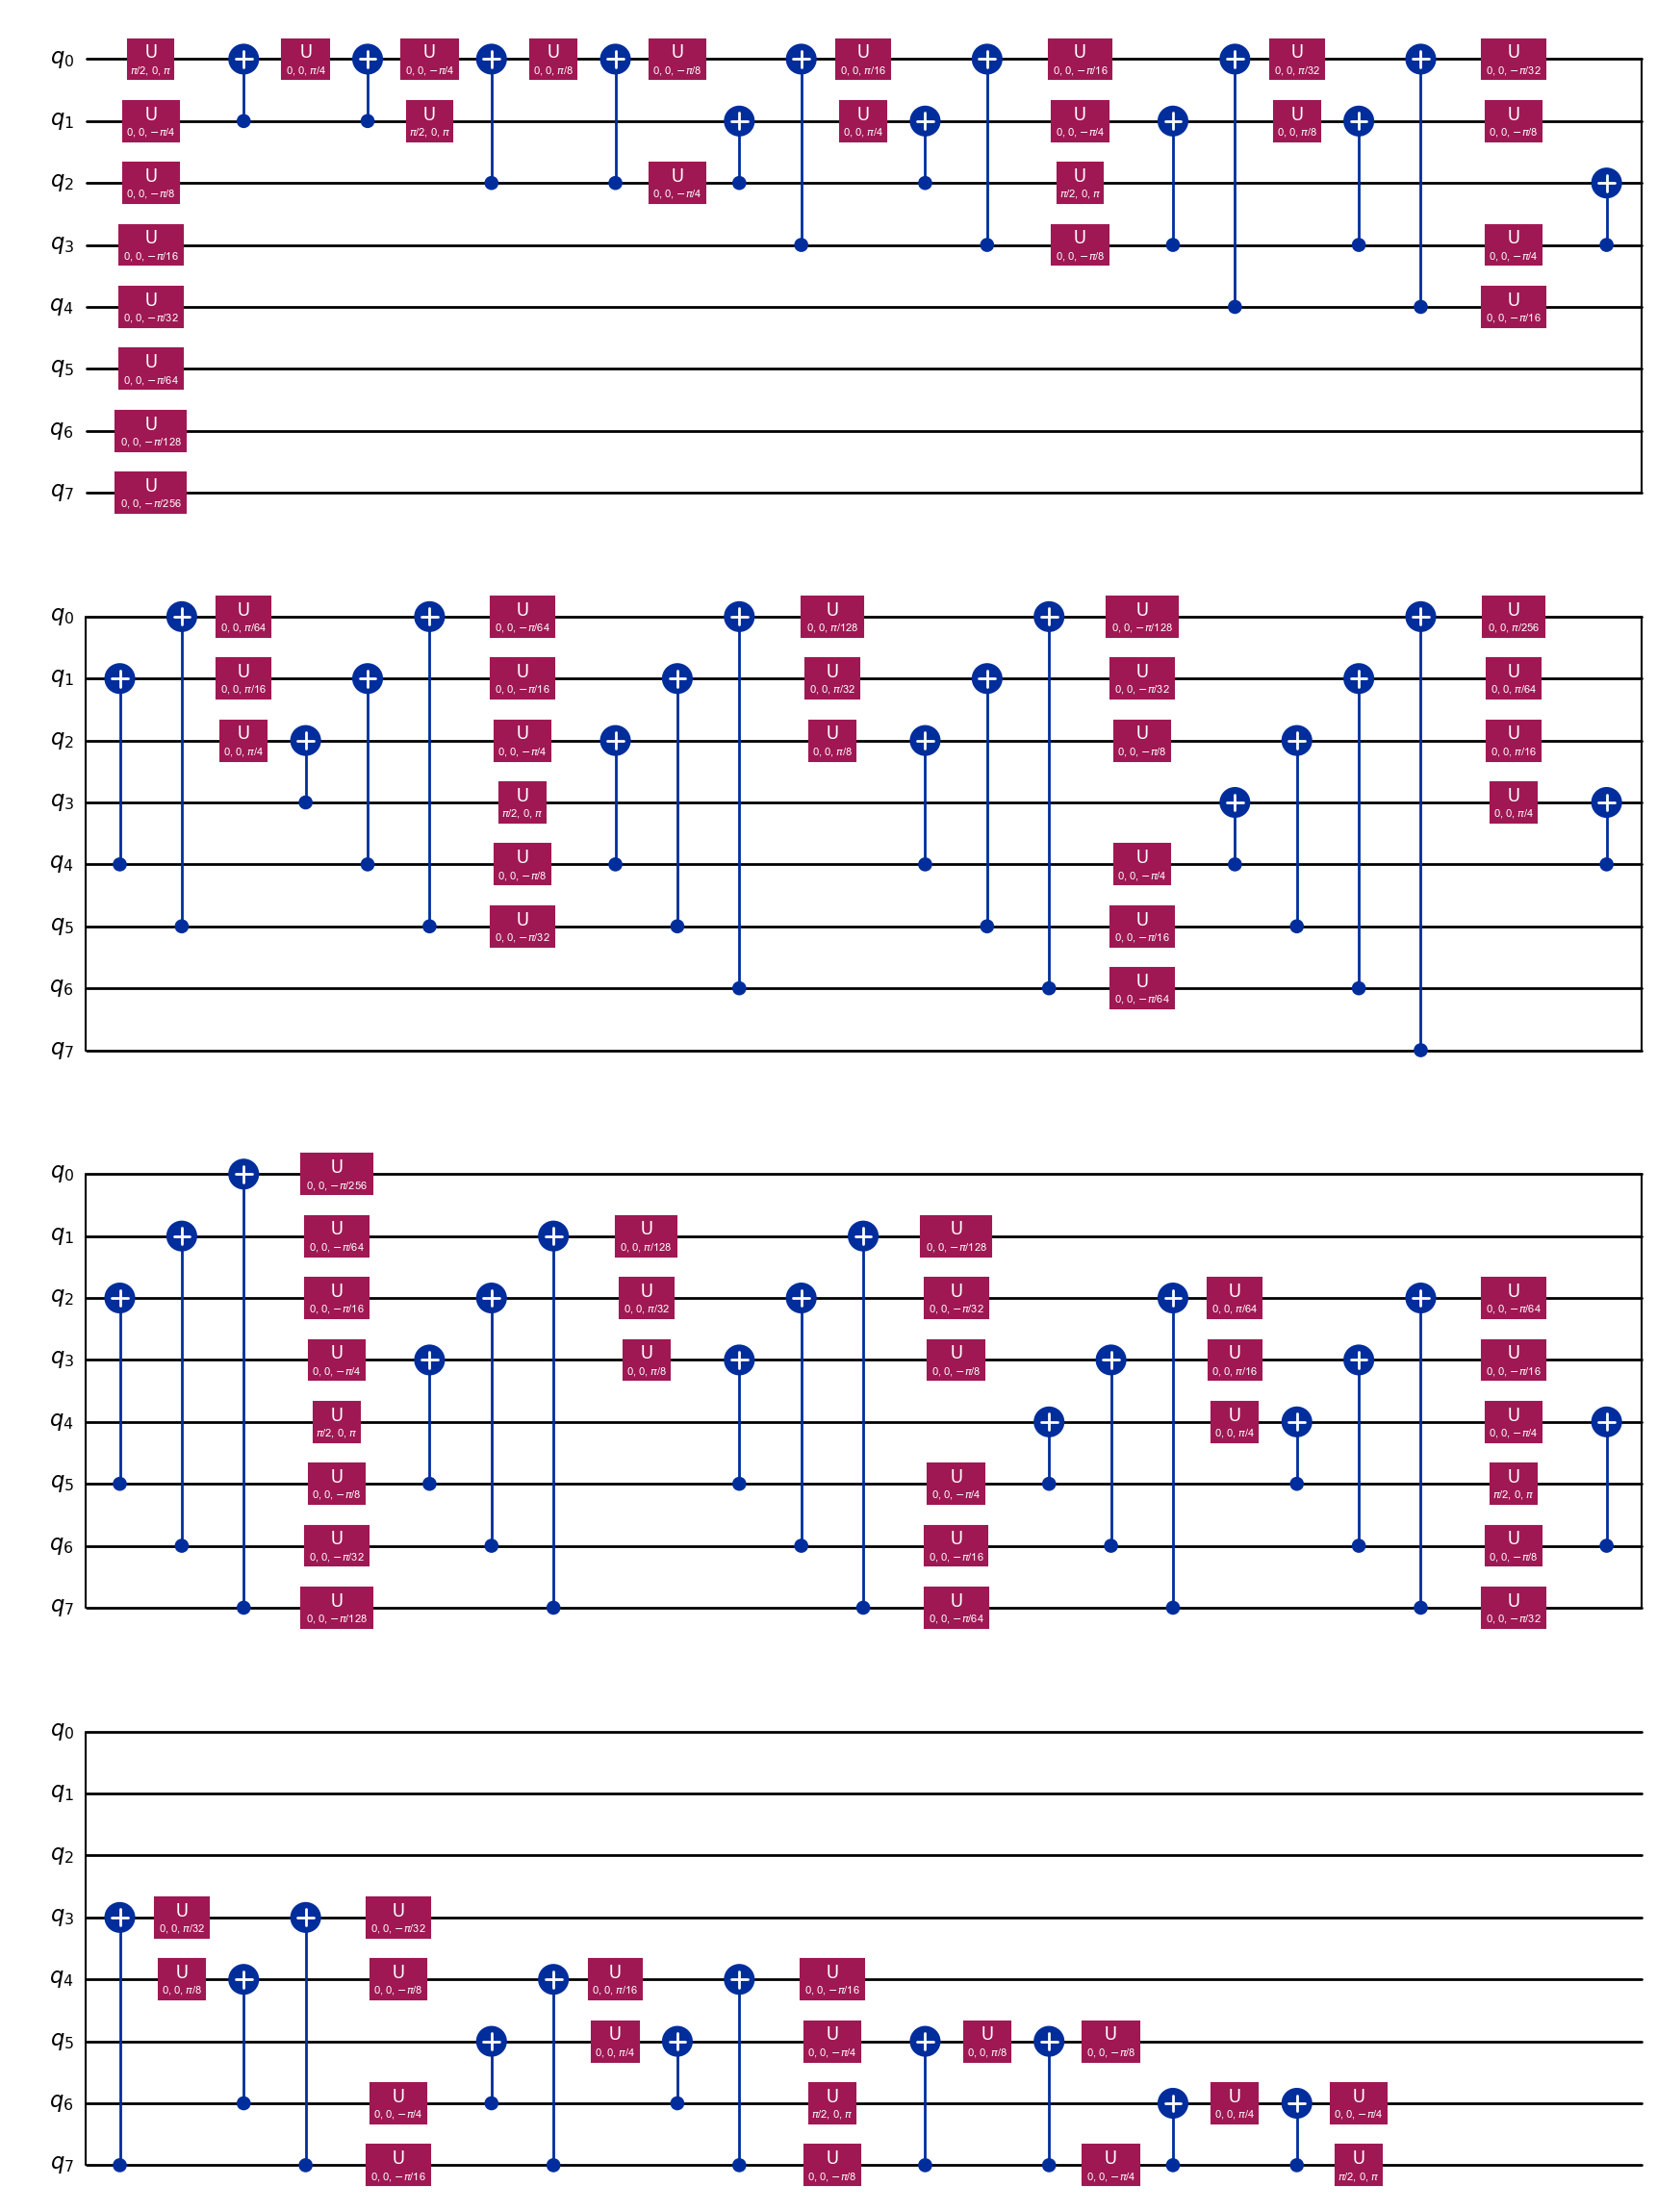

In [12]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [16]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

/var/folders/9j/mzwr55rd24j04lz6xw1m_17h0000gn/T/ipykernel_64556/3724480882.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)


,Circuit Name,Width,Depth,Total Gates,Non-local Gates
0,Swap Test + iQFT,20,13,32,11


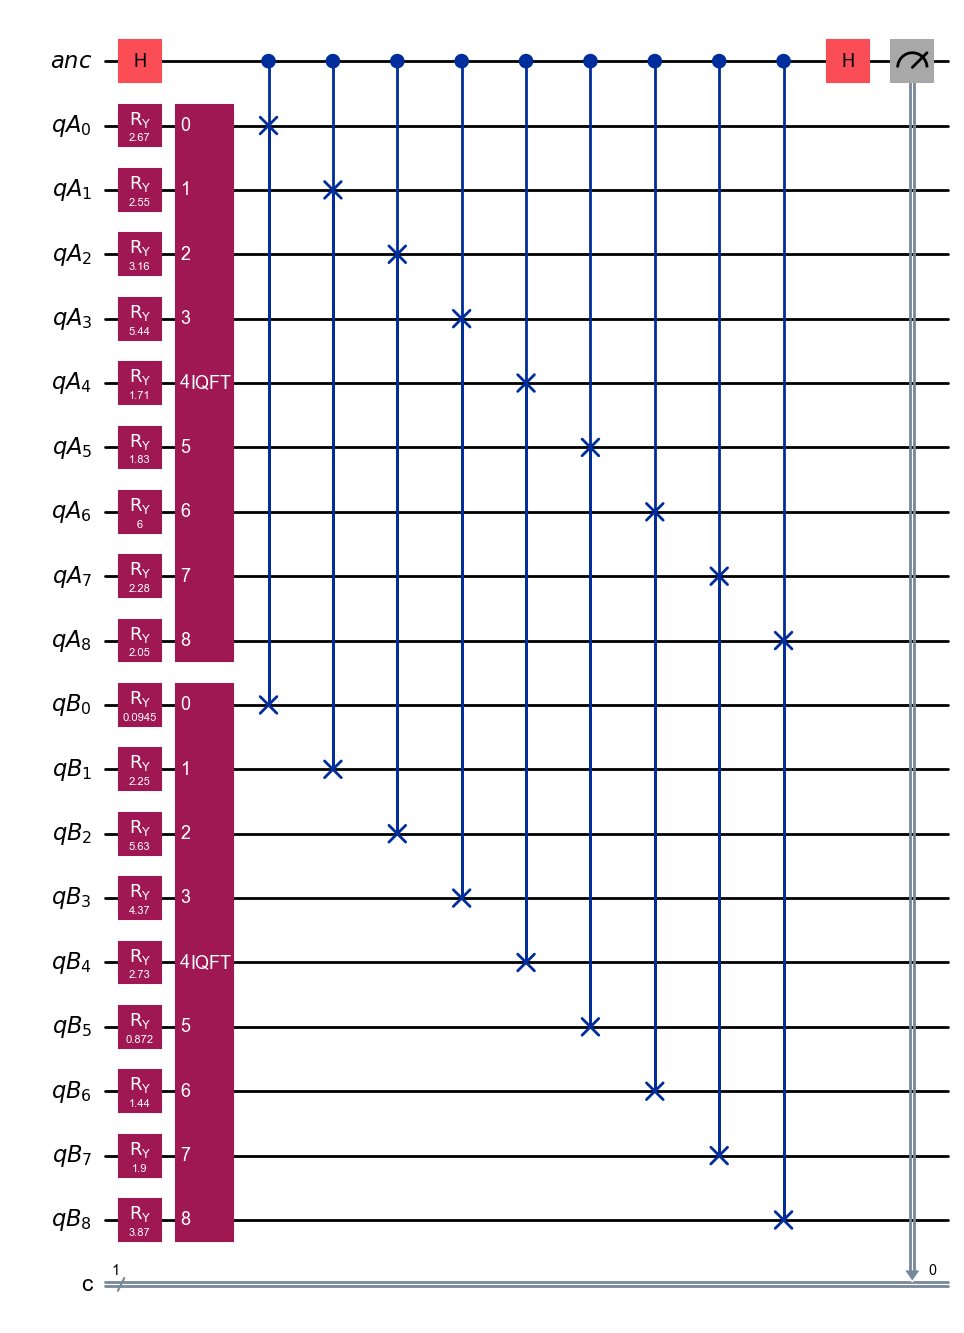

In [11]:
qc.draw('mpl')

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [23]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)

    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)

    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


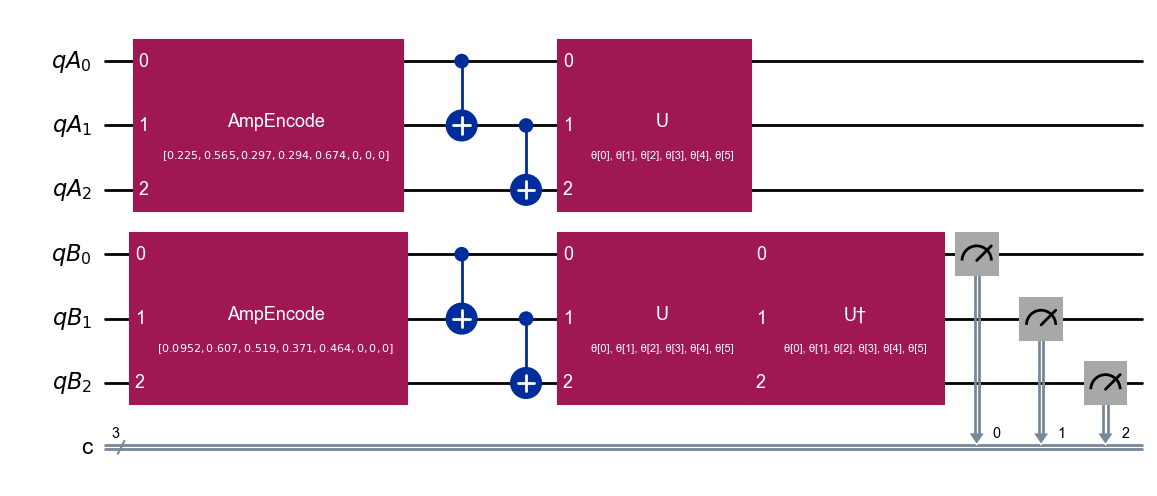

In [24]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


In [29]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library import Initialize
import numpy as np
from fisherman.overlap.all import *
def normalize(vector):
    """Normalize a vector to have unit norm."""
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm

def amplitude_encode(circuit, qubits, data):
    """Encode data into quantum state amplitudes."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def nearest_neighbor_entanglement(circuit, qubits):
    """Apply CNOT gates between neighboring qubits."""
    for i in range(len(qubits) - 1):
        circuit.cx(qubits[i], qubits[i + 1])

def compute_uncompute_circuit(data1, data2):
    """
    Create a quantum circuit that encodes two data vectors,
    applies a unitary transformation, uncomputes one, and measures similarity.
    """
    # Ensure data vectors are of the same length
    assert len(data1) == len(data2), "Data vectors must be the same length."

    # Determine the number of qubits needed
    num_features = len(data1)
    num_qubits = int(np.ceil(np.log2(num_features)))
    dim = 2 ** num_qubits

    # Pad and normalize data vectors
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:num_features] = normalize(data1)
    padded_data2[:num_features] = normalize(data2)

    # Create quantum and classical registers
    qA = QuantumRegister(num_qubits, name='qA')
    qB = QuantumRegister(num_qubits, name='qB')
    c = ClassicalRegister(num_qubits, name='c')
    qc = QuantumCircuit(qA, qB, c)

    # Amplitude encode both data vectors
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply nearest-neighbor entanglement
    nearest_neighbor_entanglement(qc, qA)
    nearest_neighbor_entanglement(qc, qB)

    # Define a parameterized unitary (e.g., a simple ansatz)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz',
                 entanglement='linear', reps=1, parameter_prefix='θ')
    U_gate = U.to_gate()
    U_gate.label = "U"

    # Apply U to both quantum states
    qc.append(U_gate, qA)
    qc.append(U_gate, qB)

    # Apply U† (inverse of U) to one of the states
    U_dagger = U.inverse().to_gate()
    U_dagger.label = "U†"
    qc.append(U_dagger, qB)

    # Measure the second register
    qc.measure(qB, c)

    return qc


ModuleNotFoundError: No module named 'fisherman.overlap'

In [30]:
%pip install fisherman.overlap


ERROR: Could not find a version that satisfies the requirement fisherman.overlap (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for fisherman.overlap
Note: you may need to restart the kernel to use updated packages.


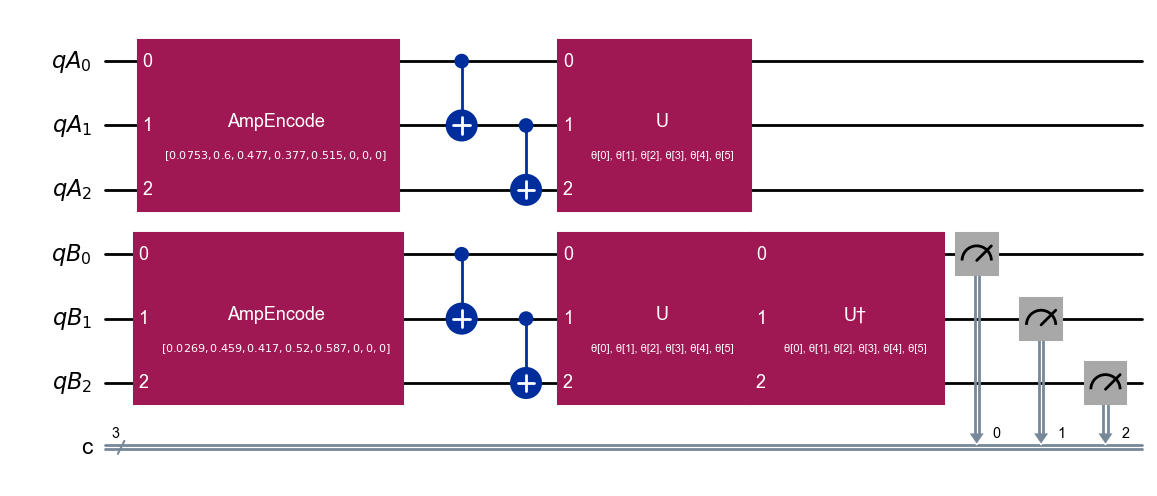

In [26]:
# Sample data vectors
data1 = np.random.rand(5)
data2 = np.random.rand(5)

# Generate the quantum circuit
qc = compute_uncompute_circuit(data1, data2)

# Visualize the circuit
qc.draw('mpl')


In [36]:
# Generate and decompose a single block of TwoLocal (U) for gate count analysis

from qiskit.circuit.library import TwoLocal
import numpy as np
import pandas as pd
from collections import Counter

# Choose number of qubits for U
num_qubits = 3  # e.g., 3-qubit U block
U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz',
             entanglement='linear', reps=1, parameter_prefix='θ')

# Decompose U into textbook gates
U_decomposed = U.decompose()

# Count gate occurrences
gate_counts = Counter(gate.name for gate, _, _ in U_decomposed.data)

# Format as DataFrame
gate_df = pd.DataFrame(gate_counts.items(), columns=["Gate", "Count"]).sort_values(by="Count", ascending=False)
# tools.display_dataframe_to_user(name="Gate Counts for One U Block", dataframe=gate_df)
gate_df


/var/folders/9j/mzwr55rd24j04lz6xw1m_17h0000gn/T/ipykernel_64556/1602751619.py:17: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  gate_counts = Counter(gate.name for gate, _, _ in U_decomposed.data)


,Gate,Count
0,ry,6
1,cz,2


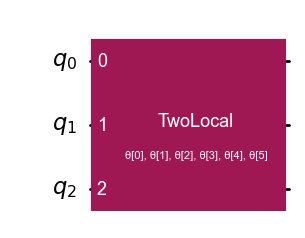

In [37]:
U.draw('mpl')  # Visualize the decomposed U block   